# Simple Model using Learning-to-Rate and optimization

Input: single principal component based on 6 basic indicators 

Output: relevance based on ranking of shape ratios for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir(os.path.expanduser('../'))

from helper_functions import calculate_returns_for_predictions, calculate_metrics

In [3]:
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider
from PortfolioOptimizer import PortfolioOptimizer

In [4]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [5]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators + ['Monthly Returns']

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.extend(indicators.T.values)

x = np.array(x)
x.shape

(7776, 6)

For target I calculate sharpe ratio for the next period, sort it by values and set a relevance from 0 to 26 depending on sharpe value

In [6]:
data_period = df_countries.loc[days_to_recalculate[0]:days_to_recalculate[1]]

returns_period = np.log(data_period).diff().dropna()
sharpe_ratio = returns_period.mean()/returns_period.std()
sharpe_ratio

United States     0.048396
Japan             0.043928
United Kingdom   -0.328966
Canada            0.280395
France            0.178218
Switzerland      -0.173104
Germany           0.209775
Australia        -0.060210
Netherlands      -0.095462
Sweden            0.173481
Hong Kong        -0.064298
Spain            -0.072430
Italy             0.100664
Singapore        -0.213353
Denmark          -0.083756
Finland           0.137049
Belgium          -0.219865
Norway           -0.176771
China            -0.223044
Taiwan            0.304264
India             0.196962
Korea            -0.126472
Brazil            0.319706
Russia            0.197139
South Africa     -0.055532
Mexico            0.145966
Malaysia          0.272365
dtype: float64

In [7]:
sorted_idx = np.argsort(sharpe_ratio.values)
sorted_sharpe = sharpe_ratio.iloc[sorted_idx]
sorted_sharpe

United Kingdom   -0.328966
China            -0.223044
Belgium          -0.219865
Singapore        -0.213353
Norway           -0.176771
Switzerland      -0.173104
Korea            -0.126472
Netherlands      -0.095462
Denmark          -0.083756
Spain            -0.072430
Hong Kong        -0.064298
Australia        -0.060210
South Africa     -0.055532
Japan             0.043928
United States     0.048396
Italy             0.100664
Finland           0.137049
Mexico            0.145966
Sweden            0.173481
France            0.178218
India             0.196962
Russia            0.197139
Germany           0.209775
Malaysia          0.272365
Canada            0.280395
Taiwan            0.304264
Brazil            0.319706
dtype: float64

In [8]:
for country in data_provider.selected_countries:
    print(country, sorted_sharpe.index.get_loc(country))

United States 14
Japan 13
United Kingdom 0
Canada 24
France 19
Switzerland 5
Germany 22
Australia 11
Netherlands 7
Sweden 18
Hong Kong 10
Spain 9
Italy 15
Singapore 3
Denmark 8
Finland 16
Belgium 2
Norway 4
China 1
Taiwan 25
India 20
Korea 6
Brazil 26
Russia 21
South Africa 12
Mexico 17
Malaysia 23


In [9]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    returns_period = np.log(data_period).diff().dropna()
    sharpe_ratio = returns_period.mean()/returns_period.std()

    sorted_idx = np.argsort(sharpe_ratio.values)
    sorted_sharpe = sharpe_ratio.iloc[sorted_idx]

    for country in data_provider.selected_countries:
        y.append(sorted_sharpe.index.get_loc(country)) # relevance 

y = np.array(y)
y.shape

(7776,)

## Splitting data into 80% train and 20% test

In [10]:
test_split = int(0.8 * (x.shape[0]/27))*27
dates_split = (int)(test_split/27)

In [11]:
# Train
dates_for_training = days_to_recalculate[:dates_split]
print(dates_for_training)

x_train = x[:test_split]
print(x_train.shape)

y_train = y[:test_split]
print(y_train.shape)

qid_train = []
for i in range(dates_for_training.shape[0]):
    for _ in range(27):
        qid_train.append(i)

qid_train = np.array(qid_train)
print(qid_train.shape)

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2018-05-04', '2018-06-05', '2018-07-06', '2018-08-03',
               '2018-09-05', '2018-10-04', '2018-11-06', '2018-12-06',
               '2019-01-10', '2019-02-08'],
              dtype='datetime64[ns]', name='Days to rebalance', length=230, freq=None)
(6210, 6)
(6210,)
(6210,)


In [12]:
# Test
dates_for_test = days_to_recalculate[dates_split:]
print(dates_for_test)

x_test = x[test_split:]
print(x_test.shape)

y_test = y[test_split:]
print(y_test.shape)

qid_test = []
for i in range(dates_for_test.shape[0]):
    for _ in range(27):
        qid_test.append(i)

qid_test = np.array(qid_test)
print(qid_test.shape)

DatetimeIndex(['2019-03-05', '2019-04-04', '2019-05-07', '2019-06-05',
               '2019-07-05', '2019-08-06', '2019-09-04', '2019-10-04',
               '2019-11-05', '2019-12-04', '2020-01-09', '2020-02-05',
               '2020-03-04', '2020-04-03', '2020-05-06', '2020-06-03',
               '2020-07-07', '2020-08-05', '2020-09-03', '2020-10-07',
               '2020-11-04', '2020-12-03', '2021-01-06', '2021-02-03',
               '2021-03-03', '2021-04-08', '2021-05-05', '2021-06-03',
               '2021-07-07', '2021-08-04', '2021-09-03', '2021-10-06',
               '2021-11-03', '2021-12-03', '2022-01-11', '2022-02-08',
               '2022-03-04', '2022-04-06', '2022-05-06', '2022-06-07',
               '2022-07-06', '2022-08-03', '2022-09-07', '2022-10-06',
               '2022-11-03', '2022-12-06', '2023-01-09', '2023-02-03',
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
      

## Learn to Rank with XGB Ranker

https://xgboost.readthedocs.io/en/latest/tutorials/learning_to_rank.html

In [13]:
import xgboost as xgb

In [14]:
ranker = xgb.XGBRanker(
    n_estimators=512,
    tree_method="hist",
    device="cuda",
    learning_rate=0.01,
    reg_lambda=1.5,
    subsample=0.8,
    sampling_method="gradient_based",
    # LTR specific parameters
    objective="rank:ndcg",
    # - Enable bias estimation
    lambdarank_unbiased=True,
    # - normalization (1 / (norm + 1))
    lambdarank_bias_norm=1,
    # - Focus on the top 12 documents
    lambdarank_num_pair_per_sample=12,
    lambdarank_pair_method="topk",
    ndcg_exp_gain=True,
    eval_metric=["ndcg@1", "ndcg@3", "ndcg@5", "ndcg@10"]
)

ranker.fit(
    x_train,
    y_train,
    qid=qid_train,
    verbose=True,
)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device='cuda',
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=['ndcg@1', 'ndcg@3', 'ndcg@5', 'ndcg@10'],
          feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_bias_norm=1, lambdarank_num_pair_per_sample=12,
          lambdarank_pair_method='topk', lambdarank_unbiased=True,
          learning_rate=0.01, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, ...)

In [15]:
scores = ranker.predict(x_test)
reshaped_scores = scores.reshape(-1, 27)

Getting ranking of countries for scores

In [16]:
sorted_scores_idx = np.argsort(reshaped_scores[0])[::-1]
scored_countries = pd.Series(data=reshaped_scores[0], 
                             index=data_provider.selected_countries)
sorted_countries = scored_countries.iloc[sorted_scores_idx]
sorted_countries

South Africa      0.238336
Mexico            0.219241
Brazil            0.153068
Taiwan            0.090929
Denmark          -0.194185
India            -0.225696
Finland          -0.230738
United Kingdom   -0.249306
Russia           -0.275068
Hong Kong        -0.296648
China            -0.308043
France           -0.330956
United States    -0.342389
Italy            -0.355128
Singapore        -0.367779
Korea            -0.393032
Australia        -0.419620
Canada           -0.467360
Malaysia         -0.477381
Germany          -0.487639
Sweden           -0.500304
Netherlands      -0.564213
Belgium          -0.587043
Spain            -0.757825
Switzerland      -0.768156
Norway           -0.789653
Japan            -0.868408
dtype: float32

In [17]:
relevance = []
for country in data_provider.selected_countries:
    relevance.append(sorted_countries.index.get_loc(country))

ranked_countries = pd.Series(data=relevance, index=data_provider.selected_countries)
ranked_countries

United States     12
Japan             26
United Kingdom     7
Canada            17
France            11
Switzerland       24
Germany           19
Australia         16
Netherlands       21
Sweden            20
Hong Kong          9
Spain             23
Italy             13
Singapore         14
Denmark            4
Finland            6
Belgium           22
Norway            25
China             10
Taiwan             3
India              5
Korea             15
Brazil             2
Russia             8
South Africa       0
Mexico             1
Malaysia          18
dtype: int64

## Calculating portfolios based on rankings

In [24]:
predictions = []

for i in range(len(dates_for_test)):
    sorted_scores_idx = np.argsort(reshaped_scores[i])[::-1]
    scored_countries = pd.Series(data=reshaped_scores[i],
                                 index=data_provider.selected_countries)
    sorted_countries = scored_countries.iloc[sorted_scores_idx]

    relevance = []
    for country in data_provider.selected_countries:
        relevance.append(sorted_countries.index.get_loc(country))

    ranked_countries = pd.Series(data=relevance,
                                 index=data_provider.selected_countries)

    date = dates_for_test[i]
    ref_acwi_weights = acwi_weights.loc[str(date.year)]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_constraints_for_ranking(
            ref_acwi_weights, ranked_countries)

        data_period = df_countries.loc[:f'{date:%Y-%m-%d}'].iloc[-126:-1]

        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = ref_acwi_weights.sum(axis=1)
        scaled_acwi_weights = ref_acwi_weights.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', dates_for_test[i])

    predictions.append(optimal_portfolio.values)

predictions = np.array(predictions)

Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00
Cannot get optimal portfolio for 2023-12-05 00:00:00


## Backtesting

In [25]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [26]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [27]:
total_returns_learning_to_rate, cum_total_returns_learning_to_rate = calculate_returns_for_predictions(
    predictions, dates_for_test, df_returns_test)

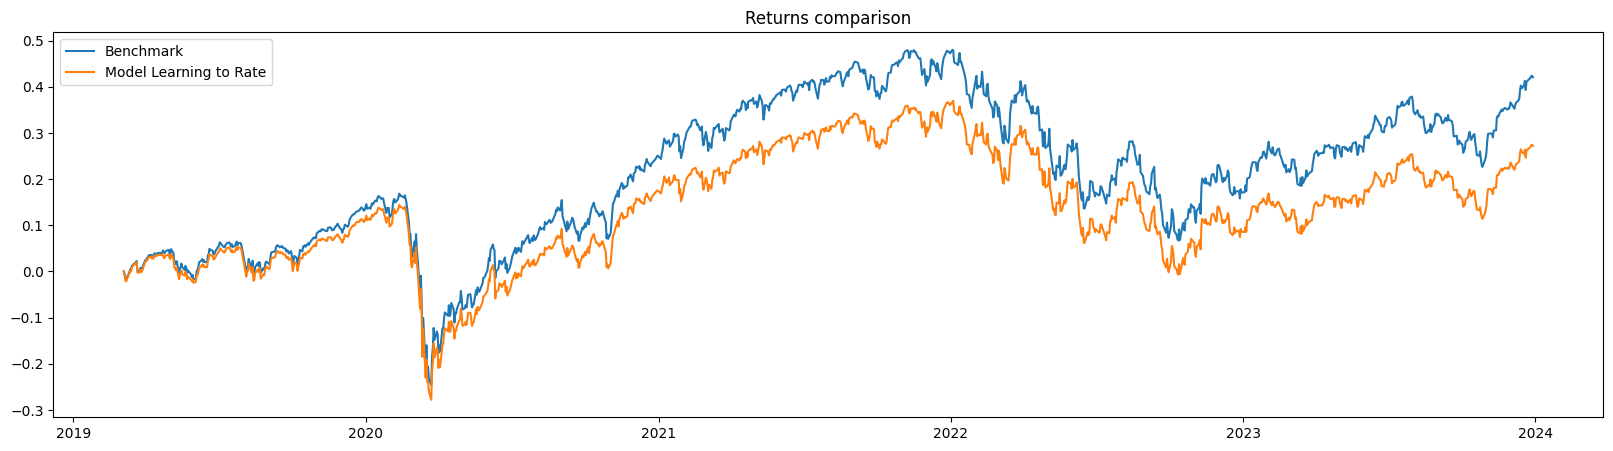

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_learning_to_rate, label='Model Learning to Rate')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [29]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_learning_to_rate, df_results, 'Model Learning to Rate', benchmark_returns)

df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Model Learning to Rate,0.051907,0.202617,0.256184,0.296547,-0.368971,499.0,0.140681,-1.068658
